<a href="https://colab.research.google.com/github/vladipako/Transfer_Entropy_Project/blob/main/TE_Package.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd
from collections import Counter
from typing import Union
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle


class Preprocessing:

  def __init__(self, n_bins: int) -> None:
    self.n_bins = n_bins

  def discretize_returns(self, returns, method = 'quantile') -> pd.Series:
    if method == 'uniform':
        bins = np.linspace(np.min(returns), np.max(returns), self.n_bins + 1)
        discretized = pd.cut(returns, bins=self.n_bins, labels=False, include_lowest=True)
    elif method == 'quantile':
        discretized = pd.qcut(returns, q=self.n_bins, labels=False, duplicates='drop')
    elif method == 'pass':
        discretized = returns
    else:
        raise ValueError("Discretization method must be either 'uniform' or 'quantile'")

    return pd.Series(discretized, index=getattr(returns, 'index', None))

  def standard_scaler(self, series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()


In [89]:
class TestDataGenerator:

  def __init__(self,
               n_samples = 10_000,
               x_scale = 1,
               y_scale = 1,
               ):

    self.n_samples = n_samples
    self.x_scale = x_scale
    self.y_scale = y_scale

  def randomData(self):
    x = np.random.normal(loc = 0, scale = self.x_scale, size = self.n_samples)
    y = np.random.normal(loc = 0, scale = self.y_scale, size = self.n_samples)
    return pd.Series(x), pd.Series(y)

  def simpleData(self):
    x = np.random.normal(loc = 0, scale = self.x_scale, size = self.n_samples)
    x_scaled = x * np.pi
    y_signal = np.sin(np.roll(x_scaled, 1))
    y = y_signal + np.random.normal(loc = 0, scale = self.y_scale, size = self.n_samples)
    # y = np.sin(np.roll(x_scaled, 1)) + np.random.normal(loc = 0, scale = self.y_scale, size = self.n_samples)
    y[0] = np.sin(x_scaled[-1]) + np.random.randn() * self.y_scale

    snr = np.var(y_signal) / np.var(y)
    print(f"Simple Data Signal-to-Noise Ratio (Var(signal) / Var(y)): {snr:.3f}")

    return pd.Series(x), pd.Series(y)

  def complexData(self):
    x = np.random.normal(loc = 0, scale = self.x_scale, size = self.n_samples)
    y = np.zeros(self.n_samples)

    y_signal = np.zeros(self.n_samples)

    y_signal[0] = 0  # No valid function values for first points
    y_signal[1] = 0

    for t in range(2, self.n_samples):
      if x[t] > 0:
          y_signal[t] = np.sin(x[t-1])  # Pure function (before noise)
      else:
          y_signal[t] = np.cos(x[t-2])**2  # Pure function (before noise)

    y = y_signal + np.random.normal(loc=0, scale=self.y_scale, size=self.n_samples)

    snr = np.var(y_signal) / np.var(y)
    print(f"Complex Data Signal-to-Noise Ratio (Var(signal) / Var(y)): {snr:.3f}")

    # Initialize the first two y values (as they depend on non-existent past x values)
    # y[0] = np.random.randn() * self.y_scale
    # y[1] = np.random.randn() * self.y_scale

    # for t in range(2, self.n_samples):
    #   if x[t] > 0:
    #       y[t] = np.sin(x[t-1]) + np.random.randn() * self.y_scale
    #   else:
    #       y[t] = np.cos(x[t-2])**2 + np.random.randn() * self.y_scale

    return pd.Series(x), pd.Series(y)

In [75]:
class ShuffleTest:
  def __init__(self,
               calculator,
               mode: str,
               x_series: Union[np.ndarray, pd.Series],
               y_series: Union[np.ndarray, pd.Series],
               lag: int,
               n_shuffles: int = 300,
               n_bins: int = 5,
               discretization_method: str = 'quantile',
               base: float = 2):

      """
      Parameters:
      x_series: Input series X
      y_series: Input series Y
      mode: Type of TE ('cumulative' or 'individual')
      lag: Number of lags
      n_shuffles: Number of shuffle iterations
      n_bins: Number of bins for discretization
      discretization_method: Method for discretization
      base: Base for logarithm
      """

      self.calculator = calculator
      self.mode = mode
      self.x_series = x_series
      self.y_series = y_series
      self.lag = lag
      self.n_shuffles = n_shuffles
      self.n_bins = n_bins
      self.discretization_method = discretization_method
      self.base = base

      self.original_te = self.calculator.processor()

  @staticmethod
  def shuffle_series(series):
      return np.random.permutation(series)

  def perform_test(self):
      """Sequential shuffle test"""
      shuffle_tes = []

      for _ in tqdm(range(self.n_shuffles), desc='Running shuffle iterations'):
          y_shuffled = self.shuffle_series(self.y_series)

          model = TransferEntropy(
              self.mode,
              self.x_series,
              y_shuffled,
              self.lag,
              n_bins=self.n_bins,
              discretization_method=self.discretization_method,
              base=self.base)

          te = model.fit()['te_value']
          shuffle_tes.append(te)

      p_value = sum(te >= self.original_te for te in shuffle_tes) / self.n_shuffles
      return shuffle_tes, p_value

  def perform_parallel_test(self):
    """Parallel shuffle test"""
    with Pool(processes=cpu_count()) as pool:
        with tqdm(total=self.n_shuffles, desc='Running shuffle iterations', position=0, leave=True) as pbar:
            shuffle_tes = []
            for result in pool.imap_unordered(self._calculate_shuffled_te,
                                            (self.shuffle_series(self.y_series) for _ in range(self.n_shuffles))):
                shuffle_tes.append(result)
                pbar.update()

    p_value = sum(shuffle_te >= self.original_te for shuffle_te in shuffle_tes) / self.n_shuffles
    return shuffle_tes, p_value

  def _calculate_shuffled_te(self, y_shuffled):
      """Helper method for parallel processing"""

      model = TransferEntropy(
          self.mode,
          self.x_series,
          y_shuffled,
          self.lag,
          n_bins=self.n_bins,
          discretization_method=self.discretization_method,
          base=self.base)

      return model.fit()['te_value']

In [76]:
class TransferEntropy:

  def __init__(self,
               mode: str,
               x_series: Union[np.ndarray, pd.Series],
               y_series: Union[np.ndarray, pd.Series],
               lag: int,
               shuffle: bool = False,
               n_shuffles: int = 300,
               twoway: bool = False,
               n_bins: int = 5,
               discretization_method: str = 'quantile',
               base: float = 2):

      """
      Parameters:
      mode (str): 'cumulative' or 'individual'
      x_series: Input series X
      y_series: Input series Y
      lag: Number of lags (cumulative) or specific lag (individual)
      shuffle (bool): Whether to perform shuffle test
      n_shuffles (int): Number of shuffles if shuffle=True
      twoway (bool): Whether to calculate bidirectional TE
      n_bins: Number of bins for discretization
      discretization_method: Method for discretization ('quantile' or 'uniform')
      base: Base for logarithm in TE calculation
      """

      self.mode = mode.lower()
      self.lag = lag
      self.do_shuffle = shuffle
      self.n_shuffles = n_shuffles
      self.twoway = twoway
      self.base = base
      self.dm = discretization_method
      self.n_bins = n_bins
      self.x_series = x_series
      self.y_series = y_series

      # Preprocess data
      preprocessor = Preprocessing(n_bins = n_bins)
      self.x_discrete = preprocessor.discretize_returns(x_series, method = discretization_method)
      self.y_discrete = preprocessor.discretize_returns(y_series, method = discretization_method)

      # Initialize appropriate calculator
      self._initialize_calculator()

      # Data validation
      self._validate_inputs(mode, lag, discretization_method)

  def _validate_inputs(self, mode: str, lag: int, disc_method: str) -> None:
    """Validate input parameters"""
    if mode.lower() not in ['cumulative', 'individual']:
        raise ValueError("Mode must be either 'cumulative' or 'individual'")
    if lag < 1:
        raise ValueError("Lag must be positive")
    if disc_method not in ['quantile', 'uniform', 'pass']:
        raise ValueError("Discretization method must be 'quantile' or 'uniform'")


  def _initialize_calculator(self) -> None:
    """Initialize appropriate TE calculator based on mode"""

    if self.mode == 'cumulative':
        self.calculator = CumulativeTransferEntropy(
            self.x_discrete,
            self.y_discrete,
            self.lag,
            self.base
        )
    else:
        self.calculator = IndividualTransferEntropy(
            self.x_discrete,
            self.y_discrete,
            self.lag,
            self.base
        )

  def fit(self, calc = None) -> dict:
    """
    Calculate Transfer Entropy based on initialization parameters.
    Returns dict with requested calculations.
    """

    calculator = calc if calc else self.calculator # needed for accurate passing of class instances in twoway calculation case

    if not self.twoway:
        # One-way TE calculation
        te_value = calculator.processor()

        if not self.do_shuffle:
            self._results = {'te_value': te_value}
        else:
            # With shuffle test
            shuffle_test = ShuffleTest(
                calculator,
                self.mode,
                self.x_series,
                self.y_series,
                self.lag,
                self.n_shuffles
            )

            shuffles, p_value = shuffle_test.perform_parallel_test()

            self._results = {
                'te_value': te_value,
                'p_value': p_value,
                'shuffles': shuffles,
                'significant': p_value < 0.05
            }
    else:
        # Two-way TE calculation
        # Forward direction (X -> Y)
        te_forward = calculator.processor()

        # Reverse direction (Y -> X)
        reverse_calculator = TransferEntropy(
            self.mode,
            self.y_discrete,
            self.x_discrete,
            self.lag,
            shuffle=self.do_shuffle,
            n_shuffles=self.n_shuffles,
            twoway=False,  # Prevent infinite recursion
        )

        reverse_results = reverse_calculator.fit()

        if not self.do_shuffle:
            self._results = {
                'x->y': {'te_value': te_forward},
                'y->x': {'te_value': reverse_results['te_value']}
            }
        else:
            # With shuffle tests for both directions
            forward_test = ShuffleTest(
                self.calculator,
                self.mode,
                self.x_series,
                self.y_series,
                self.lag,
                self.n_shuffles
            )

            fwd_shuffles, fwd_p_value = forward_test.perform_parallel_test()

            self._results = {
                'x->y': {
                    'te_value': te_forward,
                    'p_value': fwd_p_value,
                    'shuffles': fwd_shuffles,
                    'significant': fwd_p_value < 0.05
                },
                'y->x': reverse_results
            }

    return self._results

  @property
  def results(self) -> dict:
    """Get latest calculation results"""
    if not hasattr(self, '_results'):
        return None
    return self._results

  @property
  def calculator_type(self) -> str:
    """Get type of TE calculator being used"""
    return self.calculator.__class__.__name__

In [78]:
class IndividualTransferEntropy:

  def __init__(self,
               x_series: Union[np.ndarray, pd.Series],
               y_series: Union[np.ndarray, pd.Series],
               lag: int,
               n_bins: int = 5,
               base: int = 2
               ):
    """
    Initialize the TransferEntropyCalculator.

    Parameters:
    n_bins (int): Number of bins to use for discretization. Default is 5.
    discretization_method (str): Method to use for discretization.
                                  Options are 'quantile' or 'uniform'. Default is 'quantile'.
    base (float): The logarithm base to use for entropy calculations. Default is 2 (bits).

    Attributes:
    n_bins (int): Number of bins for discretization.
    discretization_method (str): Method used for discretization.
    base (float): Logarithm base for entropy calculations.
    """
    self.n_bins = n_bins
    self.base = base

    self.lag = lag

    self.x_discrete = x_series
    self.y_discrete = y_series

  def processor(self):
    joint_probs = self.calculate_joint_probability(self.y_discrete, self.x_discrete, self.lag)
    cond_probs_x = self.calculate_conditional_probability_x(self.y_discrete, self.lag)
    cond_probs_xy = self.calculate_conditional_probability_xy(self.y_discrete, self.x_discrete, self.lag)
    self.te_result = self.calculate_transfer_entropy(joint_probs, cond_probs_x, cond_probs_xy)
    return self.te_result

  def calculate_joint_probability(self, x, y, lag):
      n = len(x)
      joint_states = []
      for t in range(lag, n - 1):
          x_future = x[t + 1]
          x_past = x[t - lag + 1]  # Only consider the specific lag
          y_past = y[t - lag + 1]  # Only consider the specific lag
          joint_state = (x_future, x_past, y_past)
          joint_states.append(joint_state)
      state_counts = Counter(joint_states)
      total_counts = sum(state_counts.values())
      return {state: count / total_counts for state, count in state_counts.items()}

  def calculate_conditional_probability_x(self, x, lag):
      n = len(x)
      state_counts = Counter()
      next_state_counts = Counter()
      for t in range(lag, n - 1):
          current_state = x[t - lag + 1]  # Only consider the specific lag
          next_state = x[t + 1]
          state_counts[current_state] += 1
          next_state_counts[(next_state, current_state)] += 1

      conditional_probs = {}
      for (next_state, current_state), count in next_state_counts.items():
          if current_state in state_counts:
              conditional_probs[(next_state, current_state)] = count / state_counts[current_state]

      return conditional_probs

  def calculate_conditional_probability_xy(self, x, y, lag):
      n = len(x)
      state_counts = Counter()
      next_state_counts = Counter()
      for t in range(lag, n - 1):
          current_state_x = x[t - lag + 1]  # Only consider the specific lag
          current_state_y = y[t - lag + 1]  # Only consider the specific lag
          current_state = (current_state_x, current_state_y)
          next_state = x[t + 1]
          state_counts[current_state] += 1
          next_state_counts[(next_state,) + current_state] += 1

      conditional_probs = {}
      for (next_state, *current_state), count in next_state_counts.items():
          current_state = tuple(current_state)
          if current_state in state_counts:
              conditional_probs[(next_state, current_state)] = count / state_counts[current_state]

      return conditional_probs

  def calculate_transfer_entropy(self, joint_probs, cond_probs_x, cond_probs_xy):
      te = 0
      for (x_next, x_past, y_past), joint_prob in joint_probs.items():
          if (x_next, x_past) in cond_probs_x and (x_next, (x_past, y_past)) in cond_probs_xy:
              p_x = cond_probs_x[(x_next, x_past)]
              p_xy = cond_probs_xy[(x_next, (x_past, y_past))]
              te += joint_prob * np.log2(p_xy / p_x)
      return te

In [79]:
class CumulativeTransferEntropy:

  def __init__(self,
               x_series: Union[np.ndarray, pd.Series],
               y_series: Union[np.ndarray, pd.Series],
               lag: int,
               n_bins: int = 5,
               base: int = 2):

    """
    Initialize the TransferEntropyCalculator.

    Parameters:
    n_bins (int): Number of bins to use for discretization. Default is 5.
    discretization_method (str): Method to use for discretization.
                                  Options are 'quantile' or 'uniform'. Default is 'quantile'.
    base (float): The logarithm base to use for entropy calculations. Default is 2 (bits).

    Attributes:
    n_bins (int): Number of bins for discretization.
    discretization_method (str): Method used for discretization.
    base (float): Logarithm base for entropy calculations.
    """

    self.n_bins = n_bins
    self.base = base

    self.x_discrete = x_series
    self.y_discrete = y_series

    self.lag = lag
    self.te = None

  def __repr__(self):
    return f"TransferEntropyCalculator(n_bins={self.n_bins}, " \
            f"base={self.base})"

  def processor(self):
    joint_probs = self.calculate_joint_probability(self.y_discrete, self.x_discrete, self.lag, self.lag)
    cond_probs_x = self.calculate_conditional_probability_x(self.y_discrete, self.lag)
    cond_probs_xy = self.calculate_conditional_probability_xy(self.y_discrete, self.x_discrete, self.lag, self.lag)
    self.te_result = self.calculate_transfer_entropy(joint_probs, cond_probs_x, cond_probs_xy, self.lag)
    return self.te_result

  def calculate_joint_probability(self, x, y, k, l):
      n = len(x)
      joint_states = []
      for t in range(max(k, l), n - 1):
          x_future = x[t + 1]
          x_past = tuple(x[t - i] for i in range(k))
          y_past = tuple(y[t - i] for i in range(l))
          joint_state = (x_future,) + x_past + y_past
          joint_states.append(joint_state)
      state_counts = Counter(joint_states)
      total_counts = sum(state_counts.values())
      return {state: count / total_counts for state, count in state_counts.items()}

  def calculate_conditional_probability_x(self, x, k):
      n = len(x)
      state_counts = Counter()
      next_state_counts = Counter()
      for t in range(k, n - 1):
          current_state = tuple(x[t - i] for i in range(k))
          next_state = x[t + 1]
          state_counts[current_state] += 1
          next_state_counts[(next_state,) + current_state] += 1

      conditional_probs = {}
      for full_state, count in next_state_counts.items():
          next_state = full_state[0]
          current_state = full_state[1:]
          if current_state in state_counts:
              conditional_probs[(next_state, current_state)] = count / state_counts[current_state]

      return conditional_probs

  def calculate_conditional_probability_xy(self, x, y, k, l):
      n = len(x)
      state_counts = Counter()
      next_state_counts = Counter()
      for t in range(max(k, l), n - 1):
          current_state_x = tuple(x[t - i] for i in range(k))
          current_state_y = tuple(y[t - i] for i in range(l))
          current_state = current_state_x + current_state_y
          next_state = x[t + 1]
          state_counts[current_state] += 1
          next_state_counts[(next_state,) + current_state] += 1

      conditional_probs = {}
      for full_state, count in next_state_counts.items():
          next_state = full_state[0]
          current_state = full_state[1:]
          if current_state in state_counts:
              conditional_probs[(next_state, current_state)] = count / state_counts[current_state]

      return conditional_probs

  def calculate_transfer_entropy(self, joint_probs, cond_probs_x, cond_probs_xy, lag):
      te = 0
      for (x_next, *state), joint_prob in joint_probs.items():
          state = tuple(state)
          x_state = state[:lag]
          xy_state = state
          if (x_next, x_state) in cond_probs_x and (x_next, xy_state) in cond_probs_xy:
              p_x = cond_probs_x[(x_next, x_state)]
              p_xy = cond_probs_xy[(x_next, xy_state)]
              te += joint_prob * np.log2(p_xy / p_x)
      return te

  def shuffle_series(self, series):
      return pd.Series(np.random.permutation(series.values), index=series.index)


In [94]:
class TransferEntropyNetwork:
  def __init__(self,
               df: pd.DataFrame,
               mode: str = 'individual',
               lag: int = 1,
               shuffle: bool = True,  # Default True as we need p-values for thresholding
               n_shuffles: int = 300,
               significance_threshold: float = 0.05):
      """
      Parameters:
      df: Input dataframe where columns are variables to analyze
      mode: Type of TE calculation ('individual' or 'cumulative')
      lag: Lag for TE calculation
      shuffle: Whether to perform shuffle test
      n_shuffles: Number of shuffles for significance testing
      significance_threshold: p-value threshold for edge inclusion
      """

      self.df = df
      self.mode = mode.lower()
      self.lag = lag
      self.shuffle = shuffle
      self.n_shuffles = n_shuffles
      self.significance_threshold = significance_threshold
      self.names = df.columns

      self._te_frame = None
      self._te_matrix = None

  def calculate_te_frame(self) -> pd.DataFrame:
      """Calculate TE for all pairs of variables"""

      # Generate all pairs excluding self-pairs
      pairs = itertools.product(self.names, self.names)
      pairs = [pair for pair in pairs if pair[0] != pair[1]]

      # Create results DataFrame
      results = pd.DataFrame(
          columns=pd.MultiIndex.from_product(
              [['direct', 'reverse'], ['entropy', 'pval']],
              names=['direction', 'value']
          )
      )

      # Calculate TE for each pair
      for (elem1, elem2) in tqdm(pairs, desc='Calculating Transfer Entropy'):
          x = self.df.loc[:, elem1]
          y = self.df.loc[:, elem2]

          # Calculate TE using our new TransferEntropy class
          model = TransferEntropy(
              mode=self.mode,
              x_series=x,
              y_series=y,
              lag=self.lag,
              shuffle=self.shuffle,
              n_shuffles=self.n_shuffles,
              twoway=True  # We actually do not need both directions here as we will have those from itertools.product() call, runs extra pair of calculations. Needs work.
          )

          result = model.fit()

          key = f'{elem1} -> {elem2}'
          results.loc[key] = [
              result['x->y']['te_value'],
              result['x->y'].get('p_value', None),
              result['y->x']['te_value'],
              result['y->x'].get('p_value', None)
          ]

      self._te_frame = results
      return results

  def generate_matrix(self) -> pd.DataFrame:
      """Generate square matrix of significant TE values"""
      if self._te_frame is None:
          self.calculate_te_frame()

      n = len(self.names)
      matrix = np.zeros((n, n))

      # Fill the matrix
      for i, elem1 in enumerate(self.names):
          for j, elem2 in enumerate(self.names):
              if i != j:
                  forward_key = f'{elem1} -> {elem2}'
                  reverse_key = f'{elem2} -> {elem1}'

                  if forward_key in self._te_frame.index:
                      if not self.shuffle or self._te_frame.loc[forward_key, ('direct', 'pval')] < self.significance_threshold:
                          matrix[i, j] = self._te_frame.loc[forward_key, ('direct', 'entropy')]
                  elif reverse_key in self._te_frame.index:
                      if not self.shuffle or self._te_frame.loc[reverse_key, ('reverse', 'pval')] < self.significance_threshold:
                          matrix[i, j] = self._te_frame.loc[reverse_key, ('reverse', 'entropy')]

      self._te_matrix = pd.DataFrame(matrix, index=self.names, columns=self.names)
      return self._te_matrix.round(3)

  def plot_network(self) -> None:
      """Generate network visualization using existing TransferEntropyGraph class"""
      if self._te_matrix is None:
          self.generate_matrix()

      TransferEntropyGraph(self._te_matrix.values, list(self.names))

  @property
  def te_frame(self) -> pd.DataFrame:
      """Access TE calculation results"""
      return self._te_frame

  @property
  def te_matrix(self) -> pd.DataFrame:
      """Access TE matrix"""
      return self._te_matrix

In [81]:
class TransferEntropyGraph:

  def __init__(self, matrix: np.array,
                names: list) -> None:

    # make sure that a square matrix is passed into the constructor
    assert matrix.shape[0] == matrix.shape[1]

    self.data = matrix
    self.names = names
    self.visualise_transfer_entropy(self.data, self.names)

  def find_most_influential_node(self,
                                  matrix):

    outgoing_sum = np.sum(matrix, axis=1)
    return np.argmax(outgoing_sum)

  def draw_network_with_arrows(self,
                                G,
                                pos,
                                ax,
                                edge_weights):

    for edge in G.edges(data=True):
        start = pos[edge[0]]
        end = pos[edge[1]]
        weight = edge[2]['weight']

        # Calculate the direction vector
        dir_vec = np.array(end) - np.array(start)
        dir_vec /= np.linalg.norm(dir_vec)

        # Shorten the edge to prevent overlap with nodes
        start = np.array(start) + dir_vec * 0.15
        end = np.array(end) - dir_vec * 0.15

        # Draw the edge
        arrow = FancyArrowPatch(start, end,
                              arrowstyle='-|>',
                              color='gray',
                              mutation_scale=10,  # Size of arrowhead
                              linewidth=edge_weights[edge[:2]] * 10,
                              shrinkA=0, shrinkB=0)
        ax.add_patch(arrow)

  def visualise_transfer_entropy(self,
                                  matrix,
                                  names,
                                  threshold=0) -> None:

    G = nx.DiGraph()
    G.add_nodes_from(names)

    for i, row_name in enumerate(names):
        for j, col_name in enumerate(names):
            if i != j and matrix[i, j] > threshold:
                G.add_edge(row_name, col_name, weight=matrix[i, j])

    influential_index = self.find_most_influential_node(matrix)
    influential_node = names[influential_index]

    fig, ax = plt.subplots(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.9)

    # Draw nodes
    node_colors = ['red' if node == influential_node else 'lightblue' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", ax=ax)

    # Draw edges with arrows
    edge_weights = nx.get_edge_attributes(G, 'weight')
    self.draw_network_with_arrows(G, pos, ax, edge_weights)

    # Add edge labels
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for (u, v, d) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    plt.title("Transfer Entropy Network", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()

    plt.show()
    plt.savefig('transfer_entropy_network.png', dpi=300, bbox_inches='tight')
    # plt.close()

    print(f"Transfer entropy network visualization has been saved as 'transfer_entropy_network.png'.")
    print(f"The most influential node is: {influential_node}")

In [111]:
generator = TestDataGenerator(n_samples = 5_000)
x_series, y_series = generator.complexData()
df = pd.DataFrame({'x':x_series, 'y':y_series})

Complex Data Signal-to-Noise Ratio (Var(signal) / Var(y)): 0.269


In [83]:
te = TransferEntropy(mode = 'individual', discretization_method='uniform', n_bins = 5, x_series = x_series, y_series = y_series, lag = 2, twoway = True, shuffle = True)

In [84]:
res = te.fit()

Running shuffle iterations: 100%|██████████| 300/300 [00:18<00:00, 16.59it/s]


In [85]:
res['x->y']['te_value'], res['y->x']['te_value'], res['x->y']['p_value'], res['y->x']['p_value']

(0.02132625474961641, 0.004360059818359009, 0.0, 0.7066666666666667)

Calculating Transfer Entropy: 100%|██████████| 2/2 [00:24<00:00, 12.50s/it]


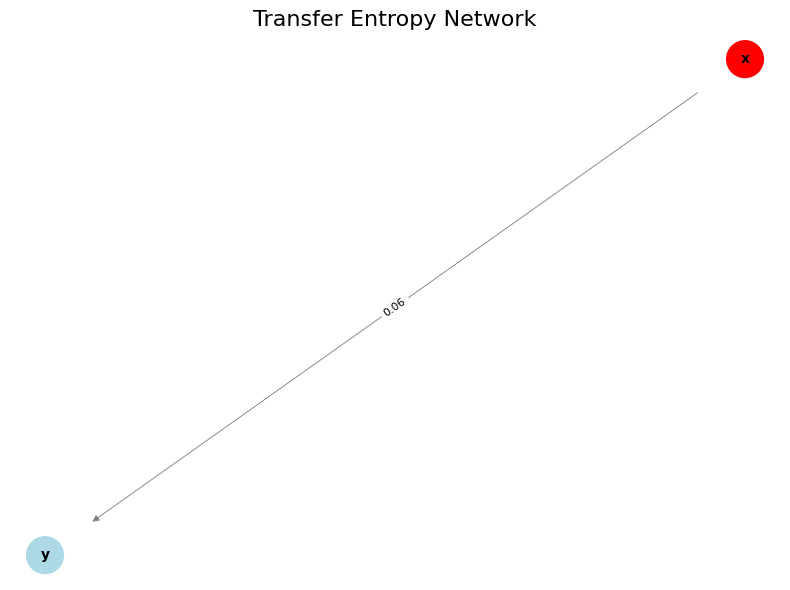

Transfer entropy network visualization has been saved as 'transfer_entropy_network.png'.
The most influential node is: x


<Figure size 640x480 with 0 Axes>

In [95]:
# Initialize network analyzer
te_network = TransferEntropyNetwork(
    df=df,
    mode='individual',
    lag=1,
    shuffle=True,
    n_shuffles=100
)

# Calculate and visualize
te_network.calculate_te_frame()  # Get detailed results
te_network.generate_matrix()     # Get matrix representation
te_network.plot_network()        # Visualize network

In [68]:
np.corrcoef(x_series[1:], y_series[:-1])

array([[ 1.        , -0.02127928],
       [-0.02127928,  1.        ]])

In [69]:
np.corrcoef(x_series[:-1], y_series[1:])

array([[1.        , 0.27766752],
       [0.27766752, 1.        ]])

# AQR Daily Factors Example for USA

In [116]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
file_path = "/content/AQR_factors_daily.xlsx"
sheets = ["BAB Factors", "UMD", "HML Devil", "SMB"]
country = "USA"
start_row = 18

data_dict = {}

for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet, skiprows=start_row)
    df = df.set_index(df.columns[0])
    df.index = pd.to_datetime(df.index)
    data_dict[sheet] = df[country]

dataframe = pd.DataFrame(data_dict).dropna()
dataframe.index.name = None
dataframe.columns = ['BAB','UMD','HML','SMB']
dataframe = dataframe.resample('ME').sum()
# dataframe.to_csv("aqr_daily_factors.csv")

Calculating Transfer Entropy: 100%|██████████| 12/12 [03:13<00:00, 16.12s/it]


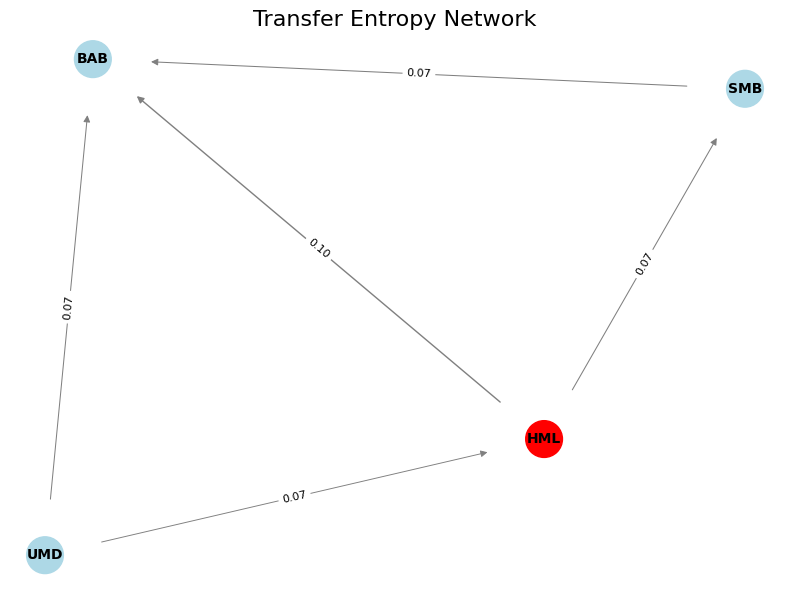

Transfer entropy network visualization has been saved as 'transfer_entropy_network.png'.
The most influential node is: HML


<Figure size 640x480 with 0 Axes>

In [118]:
# Initialize network analyzer
te_network = TransferEntropyNetwork(
    df=dataframe,
    mode='individual',
    lag=1,
    shuffle=True,
    n_shuffles=300
)

# Calculate and visualize
te_network.calculate_te_frame()  # Get detailed results
te_network.generate_matrix()     # Get matrix representation
te_network.plot_network()        # Visualize network